# Apply DWT to a known problem to explore packages

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


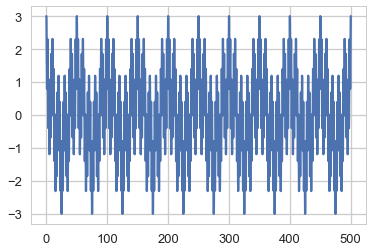

In [3]:
# Synthetic data
dt_signal = 0.1
dt_obs = 0.01
nx = 500
# x = np.arange(nx, ) * dt
x = np.linspace(0.0, nx, nx / dt_obs)

T1 = 20 * dt_signal
T2 = 100 * dt_signal
T3 = 500 * dt_signal

w1 = 2 * np.pi / T1
w2 = 2 * np.pi / T2
w3 = 2 * np.pi / T3

signal = np.cos(w1 * x) + np.cos(w2 * x) + np.cos(w3 * x)

plt.figure()
plt.plot(x, signal)

## Wavelet analysis (Morlet)

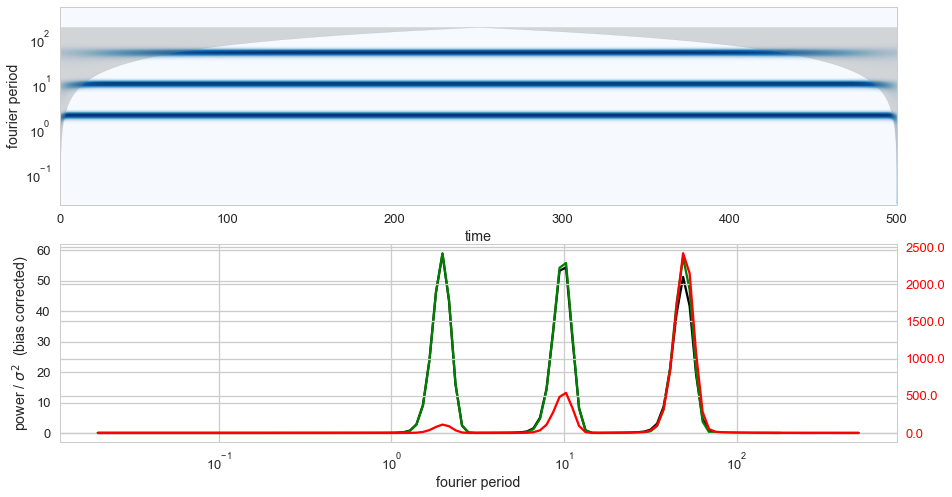

In [4]:
import wavelets
from wavelets import WaveletAnalysis

wa = WaveletAnalysis(signal, dt=dt_obs,
                     wavelet=wavelets.Morlet(), unbias=False)

power_biased = wa.global_wavelet_spectrum
wa.unbias = True
power = wa.global_wavelet_spectrum
wa.mask_coi = True
power_coi = wa.global_wavelet_spectrum

freqs = wa.fourier_periods

fig, ax = plt.subplots(nrows=2, figsize=(15, 8))

ax_transform = ax[0]
X, Y = np.meshgrid(wa.time, wa.fourier_periods)
ax_transform.set_xlabel('time')
ax_transform.set_ylabel('fourier period')
ax_transform.set_yscale('log')
ax_transform.contourf(X, Y, wa.wavelet_power, 100, cmap=cm.Blues)

# shade the region between the edge and coi
C, S = wa.coi
F = wa.fourier_period(S)
f_max = F.max()
ax_transform.fill_between(x=C, y1=F, y2=f_max, color='gray', alpha=0.3)

ax_power = ax[1]
ax_power.plot(freqs, power, 'k', label=r'unbiased all domain')
ax_power.plot(freqs, power_coi, 'g', label=r'unbiased coi only')
ax_power.set_xscale('log')
ax_power.set_xlabel('fourier period')
ax_power.set_ylabel(r'power / $\sigma^2$  (bias corrected)')

ax_power_bi = ax_power.twinx()
ax_power_bi.plot(freqs, power_biased, 'r', label='biased all domain')
ax_power_bi.set_yticklabels(ax_power_bi.get_yticks(), color='r')



## Scipy wavelets lacks the functionality for a discerete wavelet transform

## FFT

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


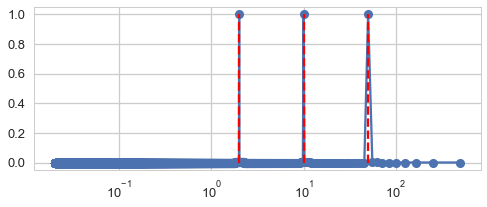

In [5]:
#  Let's use the scipy package since it has working examples
from scipy.fftpack import fft
# Use the above test signal

yf = fft(signal)
xf = scipy.fftpack.fftfreq(len(signal)) * 1 / dt_obs

plt.subplots(1, 1, figsize=(8, 3))
plt.plot(1/xf[0:len(signal)//2], 2.0 / len(signal) * np.abs(yf[0:len(signal)//2]), '-o')
plt.gca().set_xscale('log')
plt.plot([T1, T1], [0, 1], 'r--')
plt.plot([T2, T2], [0, 1], 'r--')
plt.plot([T3, T3], [0, 1], 'r--')


## MultiResolution Decomp/Haar wavelet (follows Taylor's Hypothesis)

(12, 2048)
[[-0.15278348  1.          1.         ...,  1.          1.          1.        ]
 [ 0.24839298 -0.55389189  1.         ...,  1.          1.          1.        ]
 [ 0.79308369 -0.29437069 -0.91527904 ...,  1.          1.          1.        ]
 ..., 
 [ 3.3618725   3.28799978  3.14573476 ...,  1.          1.          1.        ]
 [ 3.74601988  3.72451879  3.68286891 ...,  1.          1.          1.        ]
 [ 4.49845828  4.49126999  4.47794843 ...,  0.43766241  0.408508
   0.38494559]]


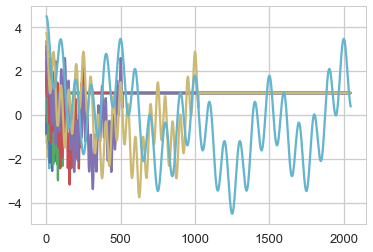

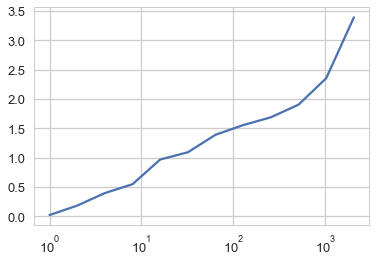

In [20]:
def multires_1var(a, M):
    # Preallocate matrices
    avg = np.ones((M, 2**(M - 1)))
    for ims in np.arange(M, dtype='int'):
        ms = int(M - ims)
        l = int(2**ms)
        nw = int((2**M) / l)
        for i in np.arange(nw):
            k = i * l + 1
            # Assigns first value in i-th window
            za  = a[k]
            # Sums over the entire window length
            for j in np.arange(k, k + l):
                za = za + a[j]
            # Calculates avg over window
            za = za / l
            # Store avg
            avg[ims, i] = za
            # Removes window avg for next modes
            for j in np.arange(k, i * l):
                a[j] = a[j] - za 
    return(avg)

scales = 2 ** (np.arange(12))
avg = multires_1var(signal, 12)
print(avg.shape)

for n in np.arange(0, 12):
    plt.plot(avg[n, :])
    
spectra = np.zeros(12)
for n in np.arange(0, 12):
    spectra[n] = np.nanmean(avg[n, 0:scales[n]] ** 2)
plt.subplots(1, 1)
plt.plot(scales, spectra)
plt.gca().set_xscale('log')
print(avg)

## Python wavelet libraries
Thoughts:
- wtf

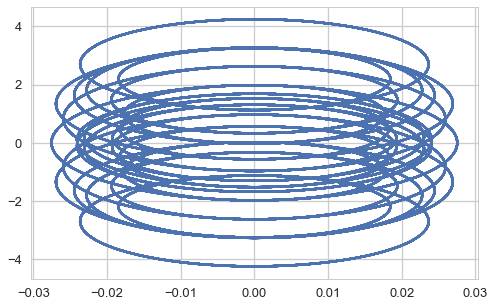

In [143]:
# The pywavelet library does not make sense to me. What is this??
scales = np.arange(1, 3600) # pretend that the synthetic signal is in seconds, then hour = largest scale?

[cfs, frequencies] = pywt.dwt(signal, wavelet)
power = (abs(cfs)) ** 2

period = 1. / frequencies

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(frequencies, cfs)

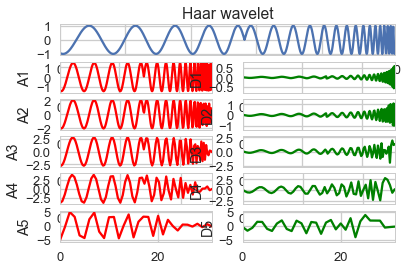

In [159]:
ecg = pywt.data.ecg()

data1 = np.concatenate((np.arange(1, 400),
                        np.arange(398, 600),
                        np.arange(601, 1024)))
x = np.linspace(0.082, 2.128, num=1024)[::-1]
data2 = np.sin(40 * np.log(x)) * np.sign((np.log(x)))

mode = pywt.Modes.sp1DWT = 1


def plot_coeffs(data, w, title, use_dwt=True):
    """Show dwt or swt coefficients for given data and wavelet."""
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []

    if use_dwt:
        for i in range(5):
            (a, d) = pywt.dwt(a, w, mode)
            ca.append(a)
            cd.append(d)
    else:
        coeffs = pywt.swt(data, w, 5)  # [(cA5, cD5), ..., (cA1, cD1)]
        for a, d in reversed(coeffs):
            ca.append(a)
            cd.append(d)

    fig = plt.figure()
    ax_main = fig.add_subplot(len(ca) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, x in enumerate(ca):
        ax = fig.add_subplot(len(ca) + 1, 2, 3 + i * 2)
        ax.plot(x, 'r')
        ax.set_ylabel("A%d" % (i + 1))
        if use_dwt:
            ax.set_xlim(0, len(x) - 1)
        else:
            ax.set_xlim(w.dec_len * i, len(x) - 1 - w.dec_len * i)

    for i, x in enumerate(cd):
        ax = fig.add_subplot(len(cd) + 1, 2, 4 + i * 2)
        ax.plot(x, 'g')
        ax.set_ylabel("D%d" % (i + 1))
        # Scale axes
        ax.set_xlim(0, len(x) - 1)
        if use_dwt:
            ax.set_ylim(min(0, 1.4 * min(x)), max(0, 1.4 * max(x)))
        else:
            vals = x[w.dec_len * (1 + i):len(x) - w.dec_len * (1 + i)]
            ax.set_ylim(min(0, 2 * min(vals)), max(0, 2 * max(vals)))


# Show DWT coefficients -- this library appears totally useless for using the haar wavelet
use_dwt = True
plot_coeffs(data2, 'db1', "Haar wavelet", use_dwt)